# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="images/pos_tagging.png" alt="POS tagging" />
</center>

In [35]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch import zeros
import torch
import torchtext
from torchtext.vocab import GloVe
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchtext.data.utils import get_tokenizer
import numpy as np
from sys import stdout
from typing import Tuple
import matplotlib.pyplot as plt
flush, write = stdout.flush , stdout.write

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Dataset download

In [36]:
!curl -O https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
!unzip -o dependency_treebank.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  446k  100  446k    0     0   572k      0 --:--:-- --:--:-- --:--:--  571k
Archive:  dependency_treebank.zip
  inflating: dependency_treebank/wsj_0093.dp  
  inflating: dependency_treebank/wsj_0065.dp  
  inflating: dependency_treebank/wsj_0039.dp  
  inflating: dependency_treebank/wsj_0182.dp  
  inflating: dependency_treebank/wsj_0186.dp  
  inflating: dependency_treebank/wsj_0041.dp  
  inflating: dependency_treebank/wsj_0018.dp  
  inflating: dependency_treebank/wsj_0105.dp  
  inflating: dependency_treebank/wsj_0149.dp  
  inflating: dependency_treebank/wsj_0194.dp  
  inflating: dependency_treebank/wsj_0055.dp  
  inflating: dependency_treebank/wsj_0187.dp  
  inflating: dependency_treebank/wsj_0143.dp  
  inflating: dependency_treebank/wsj_0052.dp  
  inflating: dependency_treebank/wsj_0064.dp  
  inflating: dependency_

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Dataset import

In [37]:
def pad(x, tot_len, pad_val):
  l = len(x)
  return ''.join([pad_val for _ in range(tot_len - l)]) + x

In [38]:
def import_corpus(folder:'str', file_base:'str', corpus_range:'range', separator:'str', data:'object'):
  keys = list(data.keys())
  data_len = len(keys)
  data['source file'] = []
  for i in corpus_range:
    f = open(f'{folder}/{file_base}{pad(str(i), 4, "0")}.dp')
    for line in f.readlines():
      entry = line.replace('\n','').split(separator)
      if len(entry) >= data_len:
        for j in range(data_len):
            data[keys[j]].append(entry[j])
        data['source file'].append(f'{file_base}{pad(str(i), 4, "0")}')
    f.close()
  return data

In [39]:
SEPARATOR = '\t'
folder = 'dependency_treebank'
file_base = 'wsj_'

train_data = pd.DataFrame(import_corpus(folder, file_base, range(1,101), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
validation_data = pd.DataFrame(import_corpus(folder, file_base, range(101,151), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
test_data = pd.DataFrame(import_corpus(folder, file_base, range(151,200), SEPARATOR, {'word/symbol':[], 'pos label':[]}))
train_data

,word/symbol,pos label,source file
0,Pierre,NNP,wsj_0001
1,Vinken,NNP,wsj_0001
2,",",",",wsj_0001
3,61,CD,wsj_0001
4,years,NNS,wsj_0001
...,...,...,...
47351,challenge,NN,wsj_0100
47352,he,PRP,wsj_0100
47353,has,VBZ,wsj_0100
47354,faced,VBN,wsj_0100


### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [40]:
glove = GloVe(name='6B', dim=100)

In [41]:
i = 50
word = train_data.iloc[i]["word/symbol"]
print(f"word at position {i}: {word}")
print(f'embedding: \n {glove[word]}')

word at position 50: director
embedding: 
 tensor([ 2.6554e-01, -7.8286e-01, -8.8447e-02, -1.0131e+00,  9.9533e-01,
        -9.4081e-01, -3.6870e-01,  3.3595e-01, -6.6131e-01,  1.8660e-02,
        -1.0583e-01, -5.0757e-01,  4.3957e-01,  1.1668e-01,  6.8358e-03,
        -1.6246e-01,  8.3221e-01, -2.9842e-02, -5.8107e-01,  5.9797e-01,
        -3.4653e-01,  3.3801e-01,  8.3349e-02, -3.3689e-01, -1.5555e-01,
         3.0370e-01,  3.6218e-01, -4.9779e-01, -1.0420e-01,  2.3055e-01,
        -9.2252e-01,  6.0625e-01, -3.4707e-01,  3.9155e-01, -1.1208e+00,
        -5.4766e-02,  9.1888e-02,  1.3057e+00,  1.7112e-01, -4.7524e-01,
        -3.8920e-01, -6.1009e-02, -6.0362e-01,  4.8490e-01,  8.2905e-01,
         1.9803e-01, -7.3324e-01, -5.5246e-01, -4.6930e-01, -1.7326e-01,
         2.5662e-01, -1.0521e+00, -3.2560e-01,  1.3647e-01,  1.2832e-01,
        -2.4086e+00, -2.8245e-01,  7.1802e-01,  8.7841e-01,  7.1353e-02,
         5.3584e-01,  5.7417e-01,  5.6343e-01, -1.2018e-01,  5.0456e-01,
        

## Useful classes

### Dataset
it is a usefull class that helps creating a dataloader which is very usefull for training a network since it automatically manages batches

In [42]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Vocabulary
It is a class that really helps with managing the words in our dataset. it creates 3 structures:
  - `word2idx` which is a dictionary that maps every word to the corresponding token.
  - `idx2word` which is a list that works as the inverse function to `word2idx` mapping back every token to the corresponding word.
  - `vectors` which is a list that maps every token to the corresponding embedding vector. If no embedding vector has been given for the corresponding word, the vectors list will return a 0 tensor.

In addition, the `length` variable will contains the length of the embedding vectors and `dim` will contains the size of the vocabulary.

In [43]:
class Vocabulary:
  """
  A class containing all the words used in the training.

  Attributes
  ----------
  word2idx : Dict
    Maps every word to the corresponding token.
  idx2word : List[str]
    Works as the inverse function to `word2idx` mapping back every token to the corresponding word.
  vectors : list[torch.Tensor]
    maps every token to the corresponding embedding vector. If no embedding vector has been given for the corresponding word, the vectors list will return a 0 tensor.
  length : int
    contains the length of the embedding vectors.
  dim : int
    contains the size of the vocabulary.
  """
  def __init__(self,
               words:'list[str]',
               pretrained_vectors: 'torchtext.vocab.Vectors' = None,
               specials:'list[str]' = ['<unk>', '<pad>'],
               vectors_length:'int' = -1) -> None:
    """
    Parameters
    ----------
    words: list[str]
      The unique words contained in the vocabulary
    pretrained_vectors: torchtext.vocab.Vectors
      the pretrained embedding containing the Tensors that will be used for the embedding. If there are words included in this class not included in the `words` list they will be added to the vocabulary too.
      It can be None but, in this case, a 0 Tensor will be created for the embedding. In the case this value is None, the `vectors_length` is mandatory.
    specials: list[str]
      A list that contains the special tokens that will be added to the vocabulary. This token will be the first tokens in the resulting list.
    vectors_length: int
      This parameter is mandatory only if the `pretrained_vectors` parameter is None. It represent the length of each Tensor used in the embedding.
    """
    self.__word2idx = {}
    self.idx2word = []
    self.vectors = []

    self.pre_trained = pretrained_vectors != None

    pre_keys = []
    pre_vectors = {}

    if self.pre_trained:
      pre_keys = pretrained_vectors.stoi.keys()
      pre_vectors = pretrained_vectors

    self.length = vectors_length
    if self.pre_trained:
      self.length = len(pretrained_vectors.vectors[0])
      if vectors_length != -1 and self.length != vectors_length:
        raise Exception(f"vectors_length {vectors_length} incompatible with length of pretrained_vectors {self.length}. Consider removing the vector length property")
    if self.length == -1:
      raise Exception("either a the pretrained_vectors or the vectors_length properties should be provided")

    idx = 0

    for word in specials:
      self.__add_word(word, idx, pre_keys, pre_vectors)
      idx += 1

    for word in pre_keys:
      self.__add_word(word, idx, pre_keys, pre_vectors)
      idx += 1

    for word in words:
      if not word in self.__word2idx:
        self.__add_word(word, idx, pre_keys, pre_vectors)
        idx += 1

    self.dim = idx
    self.vectors = torch.stack(self.vectors)

  def word2idx(self, word):
    if word in self.__word2idx:
      return self.__word2idx[word]
    return self.__word2idx['<unk>']

  def __add_word(self, word:'str', idx:'int', pre_keys:'list', pre_vectors: 'dict') -> None:
      self.__word2idx[word] = idx
      self.idx2word.append(word)
      self.vectors.append(pre_vectors[word] if word in pre_keys else zeros(self.length))

In [44]:
vocabulary = Vocabulary(np.unique(train_data['word/symbol']), glove)

In [45]:
print(vocabulary.word2idx('hello'))
print(vocabulary.idx2word[13077])
print(vocabulary.vectors[13077])

13077
hello
tensor([ 0.2669,  0.3963,  0.6169, -0.7745, -0.1039,  0.2670,  0.2788,  0.3099,
         0.0055, -0.0853,  0.7360, -0.0984,  0.5479, -0.0303,  0.3348,  0.1409,
        -0.0070,  0.3257,  0.2290,  0.4656, -0.1953,  0.3749, -0.7139, -0.5178,
         0.7704,  1.0881, -0.6601, -0.1623,  0.9119,  0.2105,  0.0475,  1.0019,
         1.1133,  0.7009, -0.0870,  0.4757,  0.1636, -0.4447,  0.4469, -0.9382,
         0.0131,  0.0860, -0.6746,  0.4966, -0.0378, -0.1104, -0.2861,  0.0746,
        -0.3153, -0.0938, -0.5707,  0.6686,  0.4531, -0.3415, -0.7166, -0.7527,
         0.0752,  0.5790, -0.1191, -0.1138, -0.1003,  0.7134, -1.1574, -0.7403,
         0.4045,  0.1802,  0.2145,  0.3764,  0.1124, -0.5364, -0.0251,  0.3189,
        -0.2501, -0.6328, -0.0118,  1.3770,  0.8601,  0.2048, -0.3681, -0.6887,
         0.5351, -0.4656,  0.2739,  0.4118, -0.8540, -0.0463,  0.1130, -0.2733,
         0.1564, -0.2033,  0.5359,  0.5978,  0.6047,  0.1373,  0.4223, -0.6128,
        -0.3849,  0.3584, -0

## Data pre-processing and preparation

---



### PosEncoding
It is a similar class to Vocabulary but for the position. It works basically the same but with the one-hot-encoding instead of the embedding.

In [46]:
class PosEncoding:
  """
  A class containing all the pos values used in the training.

  Attributes
  ----------
  pos2idx : Dict
    Maps every pos to the corresponding token.
  idx2pos : List[str]
    Works as the inverse function to `pos2idx` mapping back every token to the corresponding pos.
  encoding : list[torch.Tensor]
    maps every pos to the corresponding one-hot-encoded vector.
  dim : int
    contains the size of the vocabulary.
  """
  def __init__(self, pos_labels: 'list[str]', specials:'list[str]' = ['<pad>']) -> None:
    """
    Parameters
    ----------
    pos_labels: list[str]
      The unique words contained in the vocabulary
    specials: list[str]
      A list that contains the special pos that will be added to the vocabulary.
    """
    self.pos2idx = {}
    self.idx2pos = []
    self.encoding = []
    starting_tensor = [0 for _ in range(len(pos_labels) + len(specials))]
    idx = 0

    for pos in specials:
      self.__add_pos(pos, idx, starting_tensor)
      idx += 1

    for pos in pos_labels:
      self.__add_pos(pos, idx, starting_tensor)
      idx += 1


  def __add_pos(self, pos:'str', idx:'int', starting_tensor:'torch.Tensor'):
    self.pos2idx[pos] = idx
    self.idx2pos.append(pos)
    self.encoding.append(starting_tensor.copy())
    self.encoding[idx][idx] = 1


### Y encoding

In [47]:
pos_labels = np.unique(train_data['pos label'])
number_of_pos_labels = len(pos_labels)
print(f'there are {number_of_pos_labels} unique pos label values: ' + "\n- " + "\n- ".join(pos_labels))

there are 45 unique pos label values: 
- #
- $
- ''
- ,
- -LRB-
- -RRB-
- .
- :
- CC
- CD
- DT
- EX
- FW
- IN
- JJ
- JJR
- JJS
- LS
- MD
- NN
- NNP
- NNPS
- NNS
- PDT
- POS
- PRP
- PRP$
- RB
- RBR
- RBS
- RP
- SYM
- TO
- UH
- VB
- VBD
- VBG
- VBN
- VBP
- VBZ
- WDT
- WP
- WP$
- WRB
- ``


In [48]:
pos_encoding = PosEncoding(pos_labels)

In [49]:
print(pos_encoding.pos2idx['NNP'])
print(pos_encoding.idx2pos[21])
print(pos_encoding.encoding[21])
print(pos_encoding.encoding[21][21])

21
NNP
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1


In [50]:
def transform_data(input_data:'pd.Dataframe', vocab:'Vocabulary', encoding:'PosEncoding', sentence_split:'bool'=True) -> Tuple[torch.Tensor, torch.Tensor]:
  """
    A function that returns a tuple containing two Tensor, the first containg the tokenized words of the dataframe, the second containing the encoded labels of the dataframe.
    Parameters
    ----------
    input_data: pd.Dataframe
      The dataframe containing the data to transform. The value of the words will be checked in the 'word/symbol' column while the label will be cheked in the pos label one. If the sentence_split parameter is false, the elements will be grouped by the source file column.
    vocab: Vocabulary
      The vocabulary used to tokenize the words.
    encoding: PosEncoding
      The encoding of the labels.
    sentence_split: bool
      It tells how to split the sentences: if tru, they will be split by the '.' token, if false they will be split by the source file.
  """
  if sentence_split:
    return transform_data_by_sentences(input_data, vocab, encoding)
  return transform_data_by_files(input_data, vocab, encoding)

def tail_pad(x, tot_len, pad_element):
  l = len(x)
  return x + [pad_element for _ in range(tot_len - l)]

def transform_data_by_sentences(input_data:'pd.Dataframe', vocab:'Vocabulary', encoding:'PosEncoding') -> Tuple[torch.Tensor, torch.Tensor]:
  out_lists_x = [[]]
  out_lists_y = [[]]
  idx = 0
  for i in range(input_data.shape[0]):
    row = input_data.iloc[i, :]
    out_lists_x[idx].append(row['word/symbol'])
    out_lists_y[idx].append(row['pos label'])
    if row['word/symbol'] == '.':
      out_lists_x.append([])
      out_lists_y.append([])
      idx += 1
  max_len = 0
  for sentence in out_lists_x:
    if len(sentence) > max_len:
      max_len = len(sentence)
  for i in range(len(out_lists_x)):
    out_lists_x[i] = tail_pad(out_lists_x[i], max_len, '<pad>')
    out_lists_y[i] = tail_pad(out_lists_y[i], max_len, '<pad>')
    token_words = []
    for word in out_lists_x[i]:
      token_words.append(vocab.word2idx(word))
    encoded_y = []
    for pos in out_lists_y[i]:
      encoded_y.append(encoding.encoding[encoding.pos2idx[pos]])
    out_lists_x[i] = token_words
    out_lists_y[i] = encoded_y
  return torch.LongTensor(out_lists_x), torch.Tensor(out_lists_y)

def transform_data_by_files(input_data:'pd.Dataframe', vocab:'Vocabulary', encoding:'PosEncoding') -> Tuple[torch.Tensor, torch.Tensor]:
  out_lists_x = {}
  out_lists_y = {}
  for i in range(input_data.shape[0]):
    row = input_data.iloc[i, :]
    source = row['source file']
    if not source in out_lists_x:
      out_lists_x[source] = []
      out_lists_y[source] = []
    out_lists_x[source].append(row['word/symbol'])
    out_lists_y[source].append(row['pos label'])
  max_len = 0
  for key in out_lists_x.keys():
    if len(out_lists_x[key]) > max_len:
      max_len = len(out_lists_x[key])
  for key in out_lists_x.keys():
    out_lists_x[key] = tail_pad(out_lists_x[key], max_len, '<pad>')
    out_lists_y[key] = tail_pad(out_lists_y[key], max_len, '<pad>')
    token_words = []
    for word in out_lists_x[key]:
      token_words.append(vocab.word2idx(word))
    encoded_y = []
    for pos in out_lists_y[key]:
      encoded_y.append(encoding.encoding[encoding.pos2idx[pos]])
    out_lists_x[key] = token_words
    out_lists_y[key] = encoded_y
  return torch.LongTensor([ out_lists_x[key] for key in out_lists_x.keys()]), torch.Tensor([out_lists_y[key] for key in out_lists_y.keys()])

In [51]:
x_train, y_train = transform_data(train_data, vocabulary, pos_encoding)
x_validation, y_validation = transform_data(validation_data, vocabulary, pos_encoding)

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cpu


## LSTM Layer

A very simple layer. It creates a LSTM that can be used with the `NeuralNetwork` class.

In [53]:
class LSTMLayer(nn.Module):
  """
  A very simple layer. It creates a LSTM that can be used with the `NeuralNetwork` class.
  """
  def __init__(self, input_size:'int', hidden_size:'int', bidirectional:'bool') -> None:
    """
    Parameters
    ----------
    input_size: int
      The size of the input to the LSTM layer.
    hidden_size: int
      The number of LSTM layers.
    bidirectional: bool
      If the LSTM layer are birectional or not.
    """
    super(LSTMLayer, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)

  def forward(self, x):
    out, _ = self.lstm(x)
    return out

## Embed Layer

This layer handles the embedding of the tokens. It contains two embedding layers: the first assumes that there are pretrained vectors to use \(vector given as arguments to the `__init__` function\), the second one covers the values that are not present in the pretrained vector. The second embedding layer will be initialized with random values.

The first embedding layer can be frozen in order to avoid training it.

### How the replace Embedding layer works
![img](https://drive.google.com/uc?export=view&id=1tC7yKZwKDkv6RkBK4nU5kz3ckKocnJf4)

In [54]:
class EmbedLayer_replace(nn.Module):
  def __init__(self, vocabulary, embedding_dim):
        super(EmbedLayer_replace, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocabulary.vectors)
        self.oov_embedding = nn.Embedding(vocabulary.dim, embedding_dim)
        nn.init.uniform_(self.oov_embedding.weight, -1.0, 1.0)

  def freeze(self, freeze:'bool'):
    self.embedding.freeze = freeze


  def forward(self, x):
    embedded = self.embedding(x)
    mask = (embedded[:, :, -1] == 0).nonzero()

    embedded[mask[:, 0], mask[:, 1], :] = self.oov_embedding(x[mask[:, 0], mask[:, 1]])
    return embedded


This second version of the embedding works a bit differently: It sums the two embedding values instead of replacing the oov words only. The second random embedding should \(hopefully\) work as "fine-tuning" layer for training words and be the only embedding for non-pretrained words. We should try and see which version works the best  

### How the sum Embedding layer works
![img](https://drive.google.com/uc?export=view&id=1RrF4tv5YD7gNgjzTJXpeUq3LgQQGAAyH)

In [55]:
class EmbedLayer_sum(nn.Module):
  def __init__(self, vocabulary, embedding_dim):
        super(EmbedLayer_sum, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocabulary.vectors)
        self.oov_embedding = nn.Embedding(vocabulary.dim, embedding_dim)
        nn.init.uniform_(self.oov_embedding.weight, -1.0, 1.0)

  def freeze(self, freeze:'bool'):
    self.embedding.freeze = freeze


  def forward(self, x):
    pre_trained_embedded = self.embedding(x)

    oov_embeds = self.oov_embedding(x)
    return pre_trained_embedded + oov_embeds

## NeuralNetwork
This class is a really simple class that helps with crating a neural network. The constructor needs the optimizer and the loss that are gonna be useful for for training and the device on which the network will be trained. Each parameter can be updated in a second moment.
### Methods
 - The add method can be used to add layers to the nn.
 - The compile method can be used to actually create the nn \(the order of the layers will be the same as the order they have been passed to the add method\)
 - The train method can be used to train the nn

In [56]:
print(pos_encoding.pos2idx['#'])
print(pos_encoding.pos2idx['$'])
print(pos_encoding.pos2idx["''"])
print(pos_encoding.pos2idx[','])
print(pos_encoding.pos2idx['.'])
print(pos_encoding.pos2idx[':'])
print(pos_encoding.pos2idx['``'])

1
2
3
4
7
8
45


In [57]:
def masked_accuracy(best_guesses, targets):

  exclude_values = torch.Tensor([pos_encoding.pos2idx['<pad>'],
                    pos_encoding.pos2idx['#'],
                    pos_encoding.pos2idx['$'],
                    pos_encoding.pos2idx["''"],
                    pos_encoding.pos2idx[','],
                    pos_encoding.pos2idx['.'],
                    pos_encoding.pos2idx[':'],
                    pos_encoding.pos2idx['``']])
  idx_to_use = torch.isin(targets, exclude_values, invert=True)
  actual_targets = targets[idx_to_use]
  actual_best_guesses = best_guesses[idx_to_use]
  correct_percentage = accuracy_score(actual_targets,actual_best_guesses)
  return correct_percentage

In [58]:
class NeuralNetwork:
  """
  This class implements a simple interface to get a working neural network using pytorch.
  """
  def __init__(self, optimizer = torch.optim.Adam, loss = nn.CrossEntropyLoss(), device:'str' = 'cpu'):
      """
      Parameters
      ----------
      optimizer:
        The optimizer to use while training, default to Adam.
      loss:
        The loss function to use while training, default to crossentropy
      device: str
        The device where to train end evaluate the neural network. It must be either cpu or a valid pytorch device (e.g. cuda). Default to cpu
      """
      self.layers = []
      self.net = None
      self.optimizer = optimizer
      self.loss = loss
      self.device = device

  def add(self, *layer:'nn.Module'):
    """
      A function to add layers to the Neural network. The layers must be presentend in the order you want them to be called.
      Parameters
      ----------
      layer: nn.Module
        An arbitrary amount of layers to be added to the Neural network. The layers must be presentend in the order you want them to be called.
    """
    if not self.net is None:
      print("WARNING: the neural network has already been built. If you want the added layer to be added to the built network please rebuild it.")
    self.layers += layer

  def compile(self):
    """
      Call this method before using the Neural network for inference or training. It builds the actual neural network.
    """
    if not self.net is None:
      print("WARNING: the previous network will be discarded. Please retrain the network before using it for inference.")
    self.net = nn.Sequential(*self.layers)
    self.net = self.net.to(self.device)
    return self

  def __str__(self) -> str:
     return f"{self.net}"

  def __call__(self, x):
    return self.net(x)

  def train(self,
            train_loader:'torch.utils.data.DataLoader',
            validation_loader:'torch.utils.data.DataLoader',
            learning_rate:'float'=.1,
            epochs:'int'=10,
            metrics:'dict[str,callable]' = {'accuracy': masked_accuracy}) -> Tuple[dict[str,list[float]],dict[str,list[float]]]:
    """
      A simple training loop for the neural network. It returns the epochs loss and accuracy history both on the training and the validation set. The tuple will be formatted as:
      train loss, train accuracy, val loss, val accuracy
      Parameters
      ----------
      train_loader: torch.utils.data.DataLoader
        A dataloader containing the dataset that will be used for training the network
      validation_loader: torch.utils.data.DataLoader
        A dataloader containing the dataset that will be used for validate the network at the end of each epoch
      learning_rate: float
        The learning rate that will be used in the optimizer to train the network. Default to .1
      epochs:
        The number of training epochs, default to 10.
    """
    net = self.net
    optimizer = self.optimizer(net.parameters(), learning_rate)

    train_loss_history = []
    val_loss_history = []

    start_ts = time.time()

    total_batch = int(len(train_loader.dataset) / train_loader.batch_size)
    train_metrics_scores = {}
    val_metrics_scores = {}
    for key in metrics:
        train_metrics_scores[key] = []
        val_metrics_scores[key] = []

    for epoch in range(epochs):
        net.train()
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(self.device), data[1].to(self.device)

            outputs = net(inputs)
            n_batch, n_sequence, n_classes = outputs.shape
            loss_outputs = torch.reshape(outputs, (n_batch, n_classes, n_sequence))
            loss_labels = torch.reshape(labels, (n_batch, n_classes, n_sequence))
            loss = self.loss(loss_outputs, loss_labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            predicted_classes = torch.max(outputs, len(outputs.shape) - 1)[1].view(-1).cpu()
            normal_labels = torch.max(labels, len(labels.shape) - 1)[1].view(-1).cpu()

            stdout.write(f"\rbatch {batch_idx + 1}/{total_batch} ----- loss: {loss.cpu()} ----- {'-----'.join([f'{key}: {metrics[key](predicted_classes, normal_labels)}' for key in metrics.keys()])}")
            stdout.flush()

        val_metrics, val_loss = self.__validate(validation_loader, metrics)
        for key in metrics:
          val_metrics_scores[key].append(val_metrics[key])
        val_loss_history.append(val_loss)
        train_metrics, train_loss = self.__validate(train_loader, metrics)
        for key in metrics:
          train_metrics_scores[key].append(train_metrics[key])
        train_loss_history.append(train_loss)
        out_str = "======================================================================================================================================\n" + \
        f"EPOCH {epoch + 1} training loss: {train_loss_history[-1]} - validation loss: {val_loss_history[-1]}\n" + \
        '\n'.join([f"EPOCH {epoch + 1} training {metric}: {train_metrics_scores[metric][-1]} - validation {metric}: {val_metrics_scores[metric][-1]}" for metric in metrics.keys()]) + \
        """
======================================================================================================================================
        """
        stdout.write("\r" + " " * len(out_str) + "\r")
        stdout.flush()
        stdout.write(out_str)
        stdout.flush()
        print()
        stdout.write(f'losses: {train_loss_history} \nscores: {val_loss_history}')
        stdout.flush()
        print()
        
    train_metrics_scores['loss'] = train_loss_history
    val_metrics_scores['loss'] = val_loss_history
    return train_metrics_scores, val_metrics_scores

  def __validate(self, loader, metrics):
    losses = []
    metrics_scores = {}
    for key in metrics.keys():
      metrics_scores[key] = []
    net = self.net
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            inputs, labels = data[0].to(self.device), data[1].to(self.device)

            outputs = net(inputs)
            n_batch, n_sequence, n_classes = outputs.shape
            outputs = torch.reshape(outputs, (n_batch, n_classes, n_sequence))
            labels = torch.reshape(labels, (n_batch, n_classes, n_sequence))
            loss = self.loss(outputs, labels)
            losses.append(loss)
            outputs = torch.reshape(outputs, (n_batch, n_sequence, n_classes))
            labels = torch.reshape(labels, (n_batch, n_sequence, n_classes))
            predicted_classes = torch.max(outputs, len(outputs.shape) - 1)[1].view(-1)
            for key in metrics.keys():
              metrics_scores[key].append(metrics[key](predicted_classes.cpu(), torch.max(labels, len(labels.shape) - 1)[1].view(-1).cpu()))

    average_loss = sum(losses)/(batch_idx+1)
    mean_metrics_scores = {}
    for key in metrics.keys():
      mean_metrics_scores[key] = sum(metrics_scores[key])/len(loader)
    return mean_metrics_scores, average_loss

In [59]:
HIDDEN_LSTM_SIZE = 500
LINEAR_SIZE = 200

In [60]:
def compute_frequecies():
  frequencies = [train_data[train_data['pos label'] == name]['pos label'].count() for name in pos_encoding.pos2idx.keys()]
  max_freq = max(frequencies)
  min_freq = min(frequencies)
  norm_factor = max_freq - min_freq
  weights = [1 + ((max_freq - freq)/norm_factor)**3 for freq in frequencies]
  weights[pos_encoding.pos2idx['<pad>']] = 0
  return torch.Tensor(weights)
weights = compute_frequecies()


In [61]:
embed_layer = EmbedLayer_replace(vocabulary, 100)
embed_layer.freeze(True)
baseline = NeuralNetwork(device=device, loss=nn.CrossEntropyLoss(weights.to(device)))
baseline.add(embed_layer,
          LSTMLayer(100, HIDDEN_LSTM_SIZE, True),
          nn.Linear(HIDDEN_LSTM_SIZE * 2, y_train.shape[2])
          )
print(baseline.compile())

Sequential(
  (0): EmbedLayer_replace(
    (embedding): Embedding(402348, 100)
    (oov_embedding): Embedding(402348, 100)
  )
  (1): LSTMLayer(
    (lstm): LSTM(100, 500, batch_first=True, bidirectional=True)
  )
  (2): Linear(in_features=1000, out_features=46, bias=True)
)


In [62]:
embed_layer = EmbedLayer_replace(vocabulary, 100)
embed_layer.freeze(True)
Model1 = NeuralNetwork()
Model1.add(embed_layer,
          LSTMLayer(100, HIDDEN_LSTM_SIZE, True),
          LSTMLayer(HIDDEN_LSTM_SIZE * 2, HIDDEN_LSTM_SIZE, True),
          nn.Linear(HIDDEN_LSTM_SIZE * 2, y_train.shape[2]))
print(Model1.compile())

Sequential(
  (0): EmbedLayer_replace(
    (embedding): Embedding(402348, 100)
    (oov_embedding): Embedding(402348, 100)
  )
  (1): LSTMLayer(
    (lstm): LSTM(100, 500, batch_first=True, bidirectional=True)
  )
  (2): LSTMLayer(
    (lstm): LSTM(1000, 500, batch_first=True, bidirectional=True)
  )
  (3): Linear(in_features=1000, out_features=46, bias=True)
)


In [63]:
embed_layer = EmbedLayer_replace(vocabulary, 100)
embed_layer.freeze(True)
model2 = NeuralNetwork()
model2.add(embed_layer,
          LSTMLayer(100, HIDDEN_LSTM_SIZE, True),
          nn.Linear(HIDDEN_LSTM_SIZE * 2, LINEAR_SIZE),
          nn.ReLU(),
          nn.Linear(LINEAR_SIZE, y_train.shape[2]),
          nn.Softmax(dim=0))
print(model2.compile())

Sequential(
  (0): EmbedLayer_replace(
    (embedding): Embedding(402348, 100)
    (oov_embedding): Embedding(402348, 100)
  )
  (1): LSTMLayer(
    (lstm): LSTM(100, 500, batch_first=True, bidirectional=True)
  )
  (2): Linear(in_features=1000, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=46, bias=True)
  (5): Softmax(dim=0)
)


In [64]:
BATCH_SIZE = 50
train_dataset = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

validation_dataset = Dataset(x_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [65]:
r = baseline.train(train_loader, validation_loader, epochs=2, learning_rate=0.01)

EPOCH 1 training loss: 1.4607067108154297 - validation loss: 2.450054883956909
EPOCH 1 training accuracy: 0.10776457324155474 - validation accuracy: 0.08935782508465206
        
losses: [tensor(1.4607)] 
scores: [tensor(2.4501)]
EPOCH 2 training loss: 1.2597166299819946 - validation loss: 1.7760167121887207
EPOCH 2 training accuracy: 0.2007188635010148 - validation accuracy: 0.1820726282772384
        
losses: [tensor(1.4607), tensor(1.2597)] 
scores: [tensor(2.4501), tensor(1.7760)]


# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [102]:
def get_static_embedding(embedding_length):
    return [i for i in range(embedding_length)]

def generate_predictions(model, test_set):
    predictions = model.predict(test_set)
    return predictions



def masked_f1_score(predicted_values, targets):
    f1_class_scores = dict()
    exclude_values = torch.Tensor([pos_encoding.pos2idx['<pad>'],
                    pos_encoding.pos2idx['#'],
                    pos_encoding.pos2idx['$'],
                    pos_encoding.pos2idx["''"],
                    pos_encoding.pos2idx[','],
                    pos_encoding.pos2idx['.'],
                    pos_encoding.pos2idx[':'],
                    pos_encoding.pos2idx['``']])
    idx_to_use = torch.isin(targets, exclude_values, invert=True)
    actual_targets = targets[idx_to_use]
    actual_predictions = predicted_values[idx_to_use]
    classes = set(actual_targets.detach().numpy().tolist() + actual_predictions.detach().numpy().tolist())
    
    for cl in classes:
        true_positive, false_positive, false_negative = 0, 0, 0
        for act_targ, act_pred in zip(actual_targets, actual_predictions):
            if act_pred == cl:
                if act_pred == act_targ:
                    true_positive += 1
                else:
                    false_positive += 1
            else:
                false_negative += 1
            score = true_positive / (true_positive + (false_positive + false_negative))
            f1_class_scores[cl] = score
    
    return np.mean(np.array(list(f1_class_scores.values())))
    # correct_percentage = f1_score(actual_targets, actual_predictions, average='macro')
    # return correct_percentage

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [75]:
r_f1 = baseline.train(train_loader, validation_loader, epochs=2, learning_rate=0.01, metrics = {'f1_score': masked_f1_score})

EPOCH 1 training loss: 1.1324265003204346 - validation loss: 1.5818884372711182
EPOCH 1 training f1_score: 0.018294107050929143 - validation f1_score: 0.01802206510099769
        
losses: [tensor(1.1324)] 
scores: [tensor(1.5819)]
EPOCH 2 training loss: 1.0909565687179565 - validation loss: 1.5826140642166138
EPOCH 2 training f1_score: 0.023388235129027574 - validation f1_score: 0.022847761582783975
        
losses: [tensor(1.1324), tensor(1.0910)] 
scores: [tensor(1.5819), tensor(1.5826)]


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

In [70]:
def show_results(losses, validations, score_name):
    train_batch = np.arange(len(losses['loss'])) 
    train_loss = list(map(int, losses['loss']))
    train_score = losses[score_name]
    
    val_batch = np.arange(len(validations['loss'])) 
    val_loss = list(map(int, validations['loss']))
    val_score = validations[score_name]
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(train_batch, train_loss, color='blue', label='train_loss')
    ax1.plot(train_batch, train_score, color='green', label=f'train_{score_name}')
    ax1.set_title('Train')
    ax1.legend()
    
    ax2.plot(val_batch, val_loss, color='blue', label='val_loss')
    ax2.plot(val_batch, val_score, color='green', label=f'val_{score_name}')
    ax2.set_title('Validation')
    ax2.legend()
    
    plt.show()

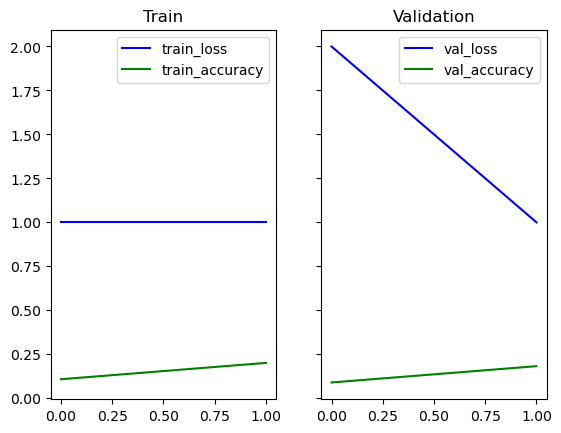

In [71]:
show_results(r[0], r[1], 'accuracy')

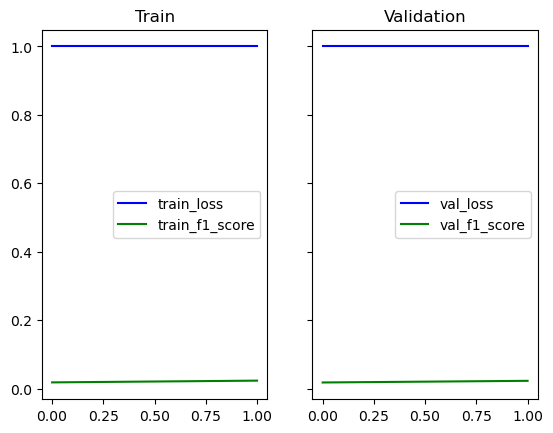

In [76]:
show_results(r_f1[0], r_f1[1], 'f1_score')

In [84]:
test_pos_labels = np.unique(test_data['pos label'])
test_pos_encoding = PosEncoding(test_pos_labels)
x_test, y_test = transform_data(test_data, vocabulary, test_pos_encoding)

In [ ]:
predictions = baseline.net(x_test)
print(predictions.shape)
print(y_test.shape)
# padded_y = torch.nn.functional.pad(input=y_test, pad=(0, 5, 0, 0), mode='constant', value=0) # I'm working on it!!!
# f1_masked = masked_f1_score(predictions, padded_y)
# print(f1_masked)

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End